---
title: "Climate DT Parameter - Data Access using DEDL HDA"
subtitle: "This notebook authenticates with the DestinE API, queries ECMWF Climate Digital Twin adaptation data based on ScenarioMIP parameters, downloads the selected forecast data using a robust retry mechanism, and visualizes it using EarthKit."
author: "Micheal Schick (EUMETSAT), Serena Avolio (EUMETSAT/Starion)"
tags: [HDA, ECMWF, Authentication, Digital Twin]
thumbnail: ../../img/ECMWF.png
license: MIT
copyright: "© 2025 EUMETSAT"
---
<div style="margin: 6px 0;">
  <a href="https://jupyter.central.data.destination-earth.eu/user-redirect/lab/tree/DestinE-DataLake-Lab/HDA/DestinE_Digital_Twins/DEDL-HDA-EO.ECMWF.DAT.DT_CLIMATE.ipynb" target="_blank" style="text-decoration: none;">
    <span class="launch">🚀 Launch in JupyterHub</span>
  </a>
</div>

<div class="alert alert-block alert-warning">
<b> Prerequisites: </b><ul>
   <li>To search and access DEDL data a <a href="https://platform.destine.eu/"> DestinE user account</a> is needed</li>
   <li>To search and access DT data an <a href="https://platform.destine.eu/support-pages/access-policy/"> upgraded access</a> is needed.</li></ul>
<b> References: </b><ul>
    <li><a href="https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/Use-of-Harmonized-Data-Access/Use-of-Harmonized-Data-Access.html">DestinE Data Lake (DEDL) Harmonized Data Access (HDA) documentation</a> </li>
    <li> <a href="https://destine.ecmwf.int/climate-change-adaptation-digital-twin-climate-dt/">Climate Change Adaptation DT (Climate DT)</a></li>
    <li> <a href="https://confluence.ecmwf.int/display/DDCZ/Climate+DT+Phase+1+data+catalogue">Climate DT data catalogue</a></li></ul>
<b> Credit: </b><ul>
    <li> Earthkit and HDA Polytope used in this context are both packages provided by the European Centre for Medium-Range Weather Forecasts (ECMWF).</li></ul>
</div>


# Climate DT - Parameter Plot - Data Access using DEDL HDA

### Contents
- **Objective:** This notebook has the aim to show how to how to use the **HDA (Harmonized Data Access)** API to query and access Climate DT data parameters and plot vector data.
    Below the main steps covered by this tutorial.
    1. [Setup](#DEDL-HDA-EO.ECMWF.DAT.DT_CLIMATE.ipynb-Setup): Import the required libraries. 
    2. [Order and Download](#DEDL-HDA-EO.ECMWF.DAT.DT_CLIMATE.ipynb-Order-and-Download): How to filter and download Climate DT data.
    3. [Plot](#DEDL-HDA-EO.ECMWF.DAT.DT_CLIMATE.ipynb-EarthKit): How to visualize hourly data on single levels data through Earthkit.

  
       
- **Data Sources:** https://destine.ecmwf.int/climate-change-adaptation-digital-twin-climate-dt/
- **Methods:** The data request is performed using HDA REST API. The variables used in this notebook are the "U component of wind" and "V component of wind"


- **Prerequisites:** 
   - To search and access DEDL data a <a href="https://platform.destine.eu/"> DestinE user account</a> is needed
   - To search and access DT data an <a href="https://platform.destine.eu/support-pages/access-policy/"> upgraded access</a> is needed.
- **Expected Output:**
    - 2 grib file files containing the requested data,
    - 1 map plot of the winds intensity.


(DEDL-HDA-EO.ECMWF.DAT.DT_CLIMATE.ipynb-Setup)=
# Setup

Import all the required packages.

In [1]:
import destinelab as deauth
import json
import datetime
import importlib.metadata

import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import os
from getpass import getpass
from tqdm import tqdm
import time
from datetime import datetime
from urllib.parse import unquote
from time import sleep
from IPython.display import JSON
import ipywidgets as w

(DEDL-HDA-EO.ECMWF.DAT.DT_CLIMATE.ipynb-Order-and-Download)=
# Order and Download

## Obtain Authentication Token

To access data we need to be authenticated. 

Below how to request of an authentication token using the destinelab package.

In [2]:
DESP_USERNAME = input("Please input your DESP username: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


Response code: 200
DEDL/DESP Access Token Obtained Successfully


### Check if DT access is granted

If DT access is not granted, you will not be able to execute the rest of the notebook.

In [3]:
import importlib
installed_version = importlib.metadata.version("destinelab")
version_number = installed_version.split('.')[1]
if((int(version_number) >= 8 and float(installed_version) < 1) or float(installed_version) >= 1):
    auth.is_DTaccess_allowed(access_token)

DT Output access allowed


## HDA Endpoints
HDA API is based on the Spatio Temporal Asset Catalog specification (STAC).
When accessing DestinE data through the HDA API, it is useful to define a small set of configuration constants upfront. These typically include:

- The STAC API endpoint exposed by HDA
- The collection name

While the collection name can be specified as a constant, it does not need to be known in advance, as available collections can be discovered dynamically using the discovery API. 


In [4]:
COLLECTION_ID="EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-NEMO.R1"

In [5]:
HDA_STAC_ENDPOINT="https://hda.data.destination-earth.eu/stac/v2"
print("STAC endpoint: ", HDA_STAC_ENDPOINT)

STAC endpoint:  https://hda.data.destination-earth.eu/stac/v2


In [6]:
HDA_DISCOVERY_ENDPOINT = HDA_STAC_ENDPOINT+'/collections'
print("HDA discovery endpoint: ", HDA_DISCOVERY_ENDPOINT)

HDA discovery endpoint:  https://hda.data.destination-earth.eu/stac/v2/collections


### HDA Discovery

For this example we want to access the Future Projection obtained using the IFS-NEMO model of the Climate Change Adaptation Digital Twin data. 
To find the right collection ID to use for querying HDA we can use the free text search offered by the HDA Discovery API searching for, e.g., Climate Change Adaptation Digital Twin, Future Projection and IFS-NEMO: <a href="https://hda-staging.lumi.data.destination-earth.eu/stac/v2/collections?limit=10&q=%22Climate%20Change%20Adaptation%20Digital%20Twin%22,%22Future%20Projection%22,%22%20IFS-NEMO%22">HDA Discovery API

The result of this operation will give us the collection ID and some other useful information like the temporal extent and the available parameters.

In [7]:

discovery_json = requests.get(HDA_DISCOVERY_ENDPOINT,params = 
                             {"q": '"Climate Change Adaptation Digital Twin","Future Projection","IFS-NEMO"'}).json()

print("\nThe discovery result give us:\nthe collection ID : ", json.dumps(discovery_json["collections"][0].get("id")))
print("\nIts time extension : ", json.dumps(discovery_json["collections"][0].get("extent").get("temporal").get("interval")))



The discovery result give us:
the collection ID :  "EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-NEMO.R1"

Its time extension :  [["2020-01-01T00:00:00Z", "2039-12-31T23:59:59Z"]]


Below the available parameters for this Climate DT collection (activity= ScenarioMIP, experiment= SSP3-7.0 and model= IFS-NEMO):

In [8]:

print("\nThe available parameters: ")
print("(Type in the text box to narrow the list. When only one item remains, its details will appear)")


keys = sorted(discovery_json["collections"][0]["cube:variables"])
txt = w.Text(description="")
out = w.Output()
def run(_):
    q = txt.value.lower()
    with out:
        out.clear_output(); 
        matches = [k for k in keys if q in k.lower()]
        for k in matches:
            print(k)
            if len(matches)==1:            
                var = discovery_json["collections"][0]["cube:variables"][k]
                print(var["description"], "\n")
                print(json.dumps(var["attrs"], indent=2))
                #print(json.dumps(discovery_json["collections"][0]["cube:variables"][k], indent=2))

                
txt.observe(run, names="value"); display(txt, out); run(None)

#print("\nThe information related to each parameter, e.g. the 2 metre temperature: ")
#JSON(discovery_json["collections"][0].get("cube:variables").get("2_metre_temperature(sfc)"))


The available parameters: 
(Type in the text box to narrow the list. When only one item remains, its details will appear)


Text(value='')

Output()

## Order and download data
After selecting the correct collection, we need to set up a filter to request our data of interest. 

We are interested to the '10 metre U wind component' and '10 metre V wind component', we can retrieve the 2 parameters details (parameter_ID, leveltype, product_type) using the Discovery API and the text box in the cell above to narrow down the list to our parameter of interest.

With this information, we can:

- use *search* to get the precise body and URL needed for the request
- use *order* to directly request the data

Examples on how to use the parameter info to search DT data can be found in the ClimateDT-ParameterPlotter.ipynb or in the ClimateDT-ROISelectionandDataAnalysis.ipynb

Below our filter of interest

In [9]:
datechoice = "20280610"
filter_params = {
        "resolution": "high",      # standard/ high 
        "time": "0000",            # choose the hourly slot(s)
        "type": "fc",              # fixed forecasted fields
        "levtype": "pl",          # Surface fields (levtype=sfc), Height level fields (levtype=hl), Pressure level fields (levtype=pl), Model Level (Levtype=ml)
        "levelist": "1000",      # 1000 hPa ~100 m (near sea level)
        "param": "131",             # 10 metre U wind component
        "date":datechoice
    }

In this example, we proceed directly with placing the data order using the order endpoint. 

The ordering workflow consists of the following steps:
- **STEP1 - submit an order** with parameters directly to the collection,
- **STEP2 - monitor** the returned STAC item status,
- **STEP3 - download** the asset when ready.

### STEP 1 - Submit an Order

We use the defined filter to submit the order

In [10]:
#timeout and step for polling (sec)
TIMEOUT = 300
STEP = 1
ONLINE_STATUS = "online"

response = requests.post(f"{HDA_STAC_ENDPOINT}/collections/{COLLECTION_ID}/order", json=filter_params, headers=auth_headers)

if response.status_code != 200:
    print(response.content)
response.raise_for_status()

ordered_item = response.json()

product_id = ordered_item["id"]
storage_tier = ordered_item["properties"].get("storage:tier", "online")
order_status = ordered_item["properties"].get("order:status", "unknown")
federation_backend = ordered_item["properties"].get("federation:backends", [None])[0]

print(f"Product ordered: {product_id}")
print(f"Provider: {federation_backend}")
print(f"Storage tier: {storage_tier} (product must have storage tier \"online\" to be downloadable)")
print(f"Order status: {order_status}")      

self_url = f"{HDA_STAC_ENDPOINT}/collections/{COLLECTION_ID}/items/{product_id}"
item = {}



Product ordered: 8d511819-199f-4203-a72c-8158f4e23352
Provider: dedt_lumi
Storage tier: offline (product must have storage tier "online" to be downloadable)
Order status: ordered


### STEP 2 - Monitor the status

The status of an order can be:
- shipping, that means that the order is in progress;
- succeeded, that means that the order is completed;
- failed, that means that the order is in error.

In [11]:
for i in range(0, TIMEOUT, STEP):
    print(f"Polling {i + 1}/{TIMEOUT // STEP}")

    response = requests.get(self_url, headers=auth_headers)
    if response.status_code != 200:
        print(response.content)
    response.raise_for_status()
    item = response.json()

    storage_tier = item["properties"].get("storage:tier", ONLINE_STATUS)

    if storage_tier == ONLINE_STATUS:
        download_url = item["assets"]["downloadLink"]["href"]
        print("Product is ready to be downloaded.")
        print(f"Asset URL: {download_url}")
        break
    sleep(STEP)
else:
    order_status = item["properties"].get("order:status", "unknown")
    print(f"We could not download the product after {TIMEOUT // STEP} tries. Current order status is {order_status}")
    
response = requests.get(download_url, stream=True, headers=auth_headers)
response.raise_for_status()

Polling 1/300
Polling 2/300
Product is ready to be downloaded.
Asset URL: https://hda-download.lumi.data.destination-earth.eu/data/dedt_lumi/EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-NEMO.R1/8d511819-199f-4203-a72c-8158f4e23352/downloadLink


### STEP 3 - Download

In [12]:
content_disposition = response.headers.get('Content-Disposition')
total_size = int(response.headers.get("content-length", 0))
if content_disposition:
    filename = content_disposition.split('filename=')[1].strip('"')
    filename = unquote(filename)
else:
    filename = os.path.basename(url)

# Open a local file in binary write mode and write the content
print(f"downloading {filename}")

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filename, 'wb') as f:
        for data in response.iter_content(1024):
            progress_bar.update(len(data))
            f.write(data)

downloading 8d511819-199f-4203-a72c-8158f4e23352.grib", attachment; 


29.2MB [00:00, 61.4MB/s]


Let's do the same with the V component of the wind

In [13]:
datechoice = "20280610"
filter_params = {
        "resolution": "high",      # standard/ high 
        "time": "0000",            # choose the hourly slot(s)
        "type": "fc",              # fixed forecasted fields
        "levtype": "pl",          # Surface fields (levtype=sfc), Height level fields (levtype=hl), Pressure level fields (levtype=pl), Model Level (Levtype=ml)
        "levelist": "1000",    
        "param": "132",             # 10 metre V wind component
        "date":datechoice
    }

### STEP 1 - Submit an Order

We use the defined filter to submit the order

In [14]:
#timeout and step for polling (sec)
TIMEOUT = 300
STEP = 1
ONLINE_STATUS = "online"

response = requests.post(f"{HDA_STAC_ENDPOINT}/collections/{COLLECTION_ID}/order", json=filter_params, headers=auth_headers)

if response.status_code != 200:
    print(response.content)
response.raise_for_status()

ordered_item = response.json()

product_id = ordered_item["id"]
storage_tier = ordered_item["properties"].get("storage:tier", "online")
order_status = ordered_item["properties"].get("order:status", "unknown")
federation_backend = ordered_item["properties"].get("federation:backends", [None])[0]

print(f"Product ordered: {product_id}")
print(f"Provider: {federation_backend}")
print(f"Storage tier: {storage_tier} (product must have storage tier \"online\" to be downloadable)")
print(f"Order status: {order_status}")      

self_url = f"{HDA_STAC_ENDPOINT}/collections/{COLLECTION_ID}/items/{product_id}"
item = {}



Product ordered: 95331ddc-34f6-47f7-bc3f-a11a99aed02a
Provider: dedt_lumi
Storage tier: offline (product must have storage tier "online" to be downloadable)
Order status: ordered


### STEP 2 - Monitor the status

The status of an order can be:
- shipping, that means that the order is in progress;
- succeeded, that means that the order is completed;
- failed, that means that the order is in error.

In [15]:
for i in range(0, TIMEOUT, STEP):
    print(f"Polling {i + 1}/{TIMEOUT // STEP}")

    response = requests.get(self_url, headers=auth_headers)
    if response.status_code != 200:
        print(response.content)
    response.raise_for_status()
    item = response.json()

    storage_tier = item["properties"].get("storage:tier", ONLINE_STATUS)

    if storage_tier == ONLINE_STATUS:
        download_url = item["assets"]["downloadLink"]["href"]
        print("Product is ready to be downloaded.")
        print(f"Asset URL: {download_url}")
        break
    sleep(STEP)
else:
    order_status = item["properties"].get("order:status", "unknown")
    print(f"We could not download the product after {TIMEOUT // STEP} tries. Current order status is {order_status}")
    
response = requests.get(download_url, stream=True, headers=auth_headers)
response.raise_for_status()

Polling 1/300
Polling 2/300
Product is ready to be downloaded.
Asset URL: https://hda-download.lumi.data.destination-earth.eu/data/dedt_lumi/EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-NEMO.R1/95331ddc-34f6-47f7-bc3f-a11a99aed02a/downloadLink


### STEP 3 - Download

In [16]:
content_disposition = response.headers.get('Content-Disposition')
total_size = int(response.headers.get("content-length", 0))
if content_disposition:
    filenameV = content_disposition.split('filename=')[1].strip('"')
    filenameV = unquote(filenameV)
else:
    filename = os.path.basename(url)

# Open a local file in binary write mode and write the content
print(f"downloading {filenameV}")

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filenameV, 'wb') as f:
        for data in response.iter_content(1024):
            progress_bar.update(len(data))
            f.write(data)

downloading 95331ddc-34f6-47f7-bc3f-a11a99aed02a.grib", attachment; 


29.2MB [00:00, 52.8MB/s]


(DEDL-HDA-EO.ECMWF.DAT.DT_CLIMATE.ipynb-EarthKit)=
## EarthKit

Lets plot the result file with [EarthKit](https://earthkit.readthedocs.io/en/latest/index.html).

In [17]:
import earthkit.data as ekd
ds1 = ekd.from_source("file", filename)
ds2 = ekd.from_source("file", filenameV)
ds = ds1 + ds2
ds.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,u,isobaricInhPa,1000,20280610,0,0,fc,None,healpix
1,ecmf,v,isobaricInhPa,1000,20280610,0,0,fc,None,healpix


In [18]:
import earthkit.plots
chart = earthkit.plots.Map(domain=[-10, 15, 35, 45])

style = earthkit.plots.styles.Style(
    colors="plasma_r",
    levels=range(0, 22, 2),
    units="m s-1",
)



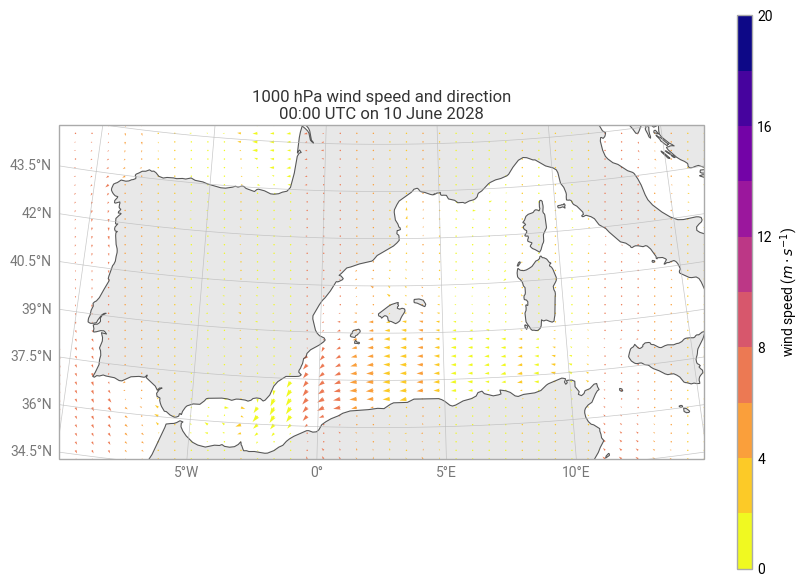

In [19]:
chart.quiver(ds, style=style)
chart.legend(label="wind speed ({units})", location="right")

chart.land()
chart.coastlines()
chart.gridlines()

chart.title(
    "{level} hPa wind speed and direction\n"
    "{time:%H:%M UTC on %-d %B %Y}"
)

chart.show()